# Phase 3: Frame Extraction for COLMAP

**Goal**: Extract frames from captured videos for COLMAP reconstruction

**Tasks**:
1. Load configuration from previous phases
2. Extract frames (skip first 3s student ID)
3. Save to `data/colmap_input/`
4. Verify frame quality and count

**Run ID**: 20251128_193628  
**Date**: 2025-11-29

---

## 1. Setup and Configuration

In [ ]:
import cv2
import numpy as np
import json
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful")
print(f"OpenCV version: {cv2.__version__}")

✅ Imports successful
OpenCV version: 4.7.0


In [ ]:
# Load existing configuration
PROJECT_ROOT = Path(r"C:\Users\user\haksoup\25_2\CV\ass3\3dgs_mini_movie")
RUN_ID = "20251128_193628"
RUN_DIR = PROJECT_ROOT / "runs" / RUN_ID

# Load config from Phase 1
config_path = RUN_DIR / "config.json"
with open(config_path, 'r') as f:
    config = json.load(f)

# Key directories
DATA_RAW = Path(config["DATA_RAW"])
DATA_RAW_SCENE = Path(config["DATA_RAW_SCENE"])
DATA_RAW_OBJECTS = Path(config["DATA_RAW_OBJECTS"])
DATA_COLMAP_INPUT = Path(config["DATA_COLMAP_INPUT"])

# Create COLMAP input directories
DATA_COLMAP_INPUT.mkdir(parents=True, exist_ok=True)

print("📁 Project Configuration:")
print(f"   PROJECT_ROOT: {PROJECT_ROOT}")
print(f"   RUN_ID: {RUN_ID}")
print(f"   RUN_DIR: {RUN_DIR}")
print(f"   DATA_RAW: {DATA_RAW}")
print(f"   DATA_COLMAP_INPUT: {DATA_COLMAP_INPUT}")
print("\n✅ Configuration loaded successfully")

📁 Project Configuration:
   PROJECT_ROOT: C:\Users\user\haksoup\25_2\CV\ass3\3dgs_mini_movie
   RUN_ID: 20251128_193628
   RUN_DIR: C:\Users\user\haksoup\25_2\CV\ass3\3dgs_mini_movie\runs\20251128_193628
   DATA_RAW: c:\Users\user\haksoup\25_2\CV\ass3\3dgs_mini_movie\data\raw
   DATA_COLMAP_INPUT: c:\Users\user\haksoup\25_2\CV\ass3\3dgs_mini_movie\data\colmap_input

✅ Configuration loaded successfully


## 2. Detect Available Videos

In [ ]:
from pathlib import Path

def find_videos(directory):
    """
    Find all video files (case-insensitive).
    
    Args:
        directory: Path object to search
        
    Returns:
        Sorted list of unique video file paths
    """
    video_extensions = {'.mp4', '.mov', '.avi'}
    videos = [
        f for f in directory.iterdir() 
        if f.is_file() and f.suffix.lower() in video_extensions
    ]
    return sorted(videos, key=lambda p: p.name)

# Scan for videos
scene_videos = find_videos(DATA_RAW_SCENE)
object_videos = find_videos(DATA_RAW_OBJECTS)

print("🎬 Available Videos:")
print(f"\nScene videos ({len(scene_videos)}):")
for video in scene_videos:
    print(f"  - {video.name}")

print(f"\nObject videos ({len(object_videos)}):")
for video in object_videos:
    print(f"  - {video.name}")

if len(scene_videos) == 0:
    print("\n⚠️ WARNING: No scene videos found!")
if len(object_videos) < 2:
    print(f"\n⚠️ WARNING: Only {len(object_videos)} object videos found (need ≥2)!")

🎬 Available Videos:

Scene videos (1):
  - IMG_7486.MOV

Object videos (2):
  - IMG_7487.MOV
  - IMG_7488.MOV


## 3. Frame Extraction Functions

In [ ]:
def get_video_info(video_path):
    """Get video metadata."""
    cap = cv2.VideoCapture(str(video_path))
    
    info = {
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'total_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'duration': cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    }
    
    cap.release()
    return info


def count_frames_in_directory(directory):
    """
    Count existing frames in a directory.
    Checks both root directory and /images subdirectory.
    
    Args:
        directory: Path to check
        
    Returns:
        tuple: (num_frames, images_location)
    """
    directory = Path(directory)
    
    # Check /images subdirectory first (COLMAP convention)
    images_dir = directory / "images"
    if images_dir.exists():
        frames = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png"))
        if len(frames) > 0:
            return len(frames), str(images_dir)
    
    # Check root directory
    frames = list(directory.glob("*.jpg")) + list(directory.glob("*.png"))
    return len(frames), str(directory)


def extract_frames(video_path, output_dir, start_second=3, frame_step=10, max_frames=None, verbose=True):
    """
    Extract frames from video.
    
    Args:
        video_path: Path to video file
        output_dir: Directory to save frames (will save to output_dir/images/)
        start_second: Seconds to skip at start (for student ID)
        frame_step: Extract every Nth frame (sampling rate)
        max_frames: Maximum number of frames to extract (None for all)
        verbose: Print progress information
    
    Returns:
        int: Number of frames extracted
    """
    video_path = Path(video_path)
    output_dir = Path(output_dir)
    
    # Create images subdirectory (COLMAP convention)
    images_dir = output_dir / "images"
    images_dir.mkdir(parents=True, exist_ok=True)
    
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Get video info
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate start frame
    start_frame = int(start_second * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    if verbose:
        print(f"\n📹 Processing: {video_path.name}")
        print(f"   Resolution: {width}x{height}")
        print(f"   FPS: {fps:.2f}")
        print(f"   Total frames: {total_frames}")
        print(f"   Skipping first {start_second}s ({start_frame} frames)")
        print(f"   Frame step: every {frame_step} frames")
        print(f"   Effective sampling rate: {fps/frame_step:.2f} fps")
    
    # Extract frames
    frame_idx = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save every frame_step-th frame
        if frame_idx % frame_step == 0:
            output_path = images_dir / f"frame_{saved_count:04d}.jpg"
            # Save as JPEG with high quality
            cv2.imwrite(str(output_path), frame, [cv2.IMWRITE_JPEG_QUALITY, 95])
            saved_count += 1
            
            if verbose and saved_count % 50 == 0:
                print(f"   Extracted {saved_count} frames...")
            
            # Check max_frames limit
            if max_frames is not None and saved_count >= max_frames:
                break
        
        frame_idx += 1
    
    cap.release()
    
    if verbose:
        print(f"   ✅ Extracted {saved_count} frames to {images_dir}")
    
    return saved_count


def display_sample_frames(frame_dir, num_samples=6):
    """
    Display sample frames for visual verification.
    
    Args:
        frame_dir: Directory containing extracted frames
        num_samples: Number of sample frames to display
    """
    frame_dir = Path(frame_dir)
    
    # Check both root and /images subdirectory
    images_subdir = frame_dir / "images"
    if images_subdir.exists():
        search_dir = images_subdir
    else:
        search_dir = frame_dir
    
    frames = sorted(search_dir.glob("*.jpg")) + sorted(search_dir.glob("*.png"))
    
    if len(frames) == 0:
        print(f"No frames found in {search_dir}")
        return
    
    # Sample frames evenly
    indices = np.linspace(0, len(frames)-1, min(num_samples, len(frames)), dtype=int)
    sample_frames = [frames[i] for i in indices]
    
    # Display in grid
    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, frame_path in enumerate(sample_frames):
        if idx >= len(axes):
            break
            
        img = cv2.imread(str(frame_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f"{frame_path.name}\n({indices[idx]}/{len(frames)-1})")
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(sample_frames), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Frame Statistics:")
    print(f"   Total frames: {len(frames)}")
    print(f"   Location: {search_dir}")
    print(f"   Sample indices: {indices.tolist()}")


print("✅ Frame extraction functions defined")

✅ Frame extraction functions defined


## 4. Extract Frames - Scene Videos

**Recommended settings for scenes:**
- Skip first 3 seconds (student ID)
- Frame step: 6-12 (2-5 fps effective rate at 30fps)
- Target: 100-300 frames per scene

In [ ]:
# Scene extraction settings
SCENE_START_SECOND = 4   # Skip student ID (adjust as needed)
SCENE_FRAME_STEP = 6     # Every 6th frame (5 fps at 30fps video)
SCENE_MAX_FRAMES = None  # No limit (or set to e.g., 300)
FORCE_REEXTRACT = False  # Set True to re-extract even if folders exist

print("🏞️ Extracting Scene Frames...")
print(f"Settings: start={SCENE_START_SECOND}s, step={SCENE_FRAME_STEP}, max={SCENE_MAX_FRAMES}")
print(f"Force re-extract: {FORCE_REEXTRACT}")
print("="*60)

scene_results = {}

for video_path in scene_videos:
    # Create dataset_id with settings embedded in folder name
    base_name = video_path.stem
    max_suffix = f"_max{SCENE_MAX_FRAMES}" if SCENE_MAX_FRAMES else ""
    dataset_id = f"scene_{base_name}_s{SCENE_START_SECOND}_step{SCENE_FRAME_STEP}{max_suffix}"
    
    dataset_dir = DATA_COLMAP_INPUT / dataset_id
    
    # Check if dataset folder already exists
    if dataset_dir.exists() and not FORCE_REEXTRACT:
        print(f"\n⏭️  SKIP: {dataset_id}")
        print(f"   └─ Folder already exists at {dataset_dir}")
        
        # Count existing frames
        num_existing, frames_location = count_frames_in_directory(dataset_dir)
        print(f"   └─ Found {num_existing} existing frames in {Path(frames_location).name}")
        
        scene_results[dataset_id] = {
            'video': str(video_path),
            'output_dir': str(dataset_dir),
            'num_frames': num_existing,
            'frames_location': frames_location,
            'status': 'skipped (already exists)'
        }
        continue
    
    # Extract frames
    print(f"\n🎥 Processing: {video_path.name}")
    print(f"   └─ Output: {dataset_id}")
    
    num_frames = extract_frames(
        video_path=video_path,
        output_dir=dataset_dir,
        start_second=SCENE_START_SECOND,
        frame_step=SCENE_FRAME_STEP,
        max_frames=SCENE_MAX_FRAMES,
        verbose=True
    )
    
    scene_results[dataset_id] = {
        'video': str(video_path),
        'output_dir': str(dataset_dir),
        'num_frames': num_frames,
        'frames_location': str(dataset_dir / "images"),
        'status': 'newly extracted'
    }

print("\n" + "="*60)
print("✅ Scene frame extraction complete!")
print(f"\nSummary:")
newly_extracted = [k for k, v in scene_results.items() if v['status'] == 'newly extracted']
skipped = [k for k, v in scene_results.items() if v['status'] == 'skipped (already exists)']
print(f"  - Newly extracted: {len(newly_extracted)}")
print(f"  - Skipped (existing): {len(skipped)}")
print(f"  - Total datasets: {len(scene_results)}")

🏞️ Extracting Scene Frames...
Settings: start=4s, step=6, max=None
Force re-extract: False

⏭️  SKIP: scene_IMG_7486_s4_step6
   └─ Folder already exists at c:\Users\user\haksoup\25_2\CV\ass3\3dgs_mini_movie\data\colmap_input\scene_IMG_7486_s4_step6
   └─ Found 319 existing frames in scene_IMG_7486_s4_step6

✅ Scene frame extraction complete!

Summary:
  - Newly extracted: 0
  - Skipped (existing): 1
  - Total datasets: 1



🖼️ Sample frames from scene_IMG_7486_s4_step6:


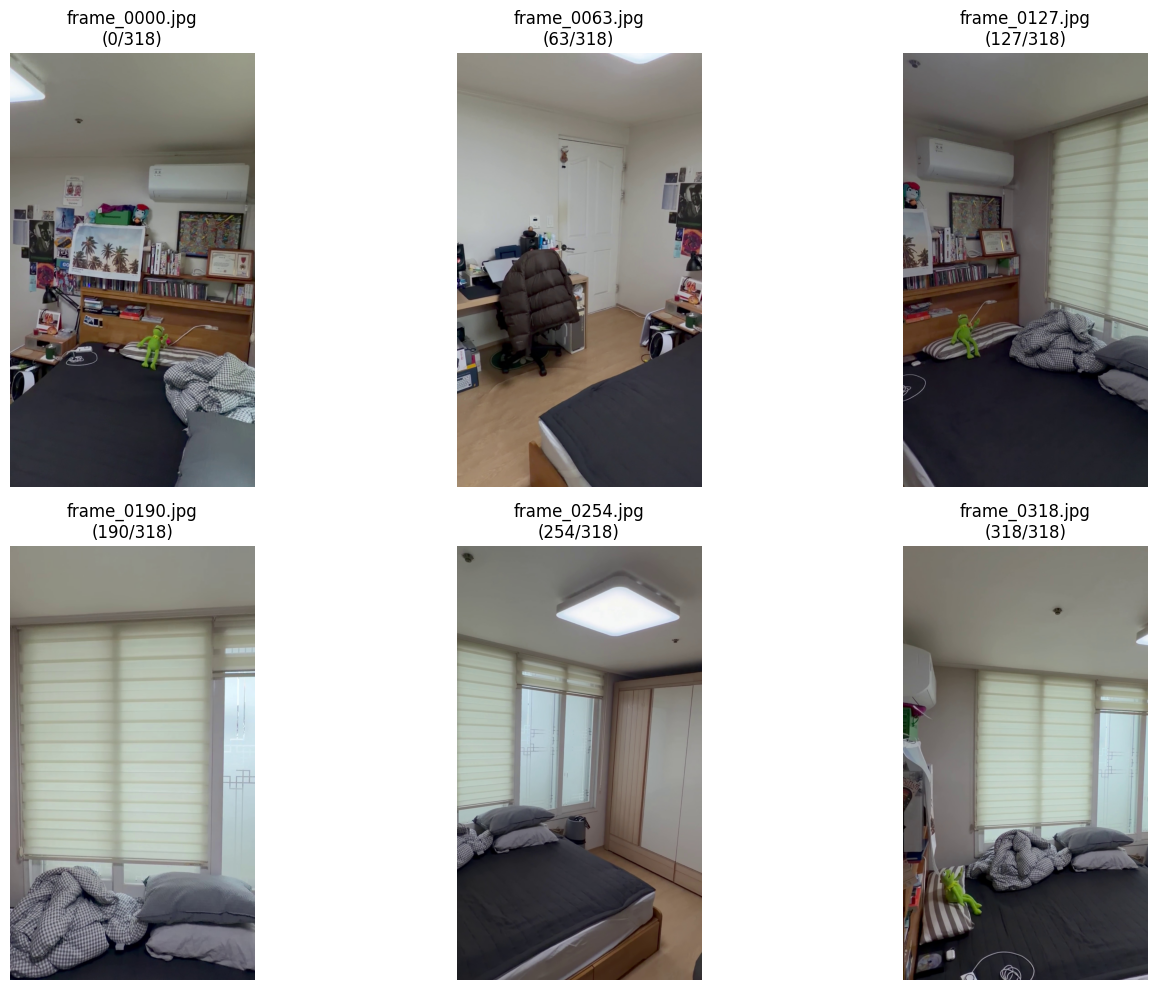


📊 Frame Statistics:
   Total frames: 319
   Location: c:\Users\user\haksoup\25_2\CV\ass3\3dgs_mini_movie\data\colmap_input\scene_IMG_7486_s4_step6
   Sample indices: [0, 63, 127, 190, 254, 318]


In [12]:
# Visualize sample frames from first scene
if len(scene_results) > 0:
    first_scene = list(scene_results.keys())[0]
    print(f"\n🖼️ Sample frames from {first_scene}:")
    display_sample_frames(scene_results[first_scene]['output_dir'], num_samples=6)